In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# !unzip '/content/drive/My Drive/Colab Notebooks/ssd-pytorch/stn_data_latest' -d data

In [0]:
from __future__ import print_function

import argparse

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms

In [0]:
import glob
import os
import pathlib
import numpy as np

import cv2
from torch.utils.data import Dataset

# def adjust_gamma(image, gamma=1.0):
#     # build a lookup table mapping the pixel values [0, 255] to
#     # their adjusted gamma values
#     invGamma = 1.0 / gamma
#     table = np.array([((i / 255.0) ** invGamma) * 255
#         for i in np.arange(0, 256)]).astype("uint8")
#     # apply gamma correction using the lookup table
#     return cv2.LUT(image, table)


class STNImagesDataset():

    def __init__(self, root, transform=None, target_transform=None, dataset_type="train"):
        self.root = pathlib.Path(root)
        self.transform = transform
        self.target_transform = target_transform
        self.dataset_type = dataset_type.lower()

        self.data = self._read_data()
        self.min_image_num = -1

        self.class_stat = None

    def _getitem(self, index):
        image_info = self.data[index]
        x_image = self._read_image(image_info['x_train'])
        y_image = self._read_image(image_info['y_train'])
        if self.transform:
            x_image = self.transform(x_image)
        if self.target_transform:
            y_image = self.transform(y_image)
        return x_image, y_image

    def __getitem__(self, index):
        x_image, y_image = self._getitem(index)
        return x_image, y_image

    def _read_data(self):
        x_train = glob.glob(str(self.root) + '/' + self.dataset_type + '/*.jpg')
        data = []
        for f in x_train:
            data.append({
                'x_train': os.path.basename(f),
                'y_train': str(os.path.basename(f.rstrip('.jpg') + '-syn.png'))
            })
        return data

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        content = ["Dataset Summary:"
                   f"Number of Images: {len(self.data)}",
                   f"Minimum Number of Images for a Class: {self.min_image_num}"]
        return "\n".join(content)

    def adjust_gamma(self, image, gamma=1.0):
        # build a lookup table mapping the pixel values [0, 255] to
        # their adjusted gamma values
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255
            for i in np.arange(0, 256)]).astype("uint8")
        # apply gamma correction using the lookup table
        return cv2.LUT(image, table)

    def _read_image(self, image_id):
        image_file = self.root / self.dataset_type / image_id
        image = cv2.imread(str(image_file))
        image = self.adjust_gamma(image, 1.5)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
        # ret, image = cv2.threshold(image, 0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        if image.shape[2] == 1:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

In [0]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((50, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_path='data/stn_data/'
# Training dataset
train_loader = torch.utils.data.DataLoader(
    STNImagesDataset(root=dataset_path, dataset_type='Train', transform=transform, target_transform=transform),
    batch_size=32, shuffle=True, num_workers=0)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    STNImagesDataset(root=dataset_path, dataset_type='Test', transform=transform, target_transform=transform),
    batch_size=32, shuffle=True, num_workers=0)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=1, bias=False)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=1, bias=False)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=1, bias=False)
        self.fc1 = nn.Linear(32 * 1 * 7, 1024)
        self.fc2 = nn.Linear(1024, 6)

        # Initialize the weights/bias with identity transformation
        self.fc2.weight.data.zero_()
        self.fc2.bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def forward(self, xs):
        # transform the input
        x = F.relu(self.conv1(xs))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32 * 1 * 7)
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.view(-1, 2, 3)  # change it to the 2x3 matrix

        grid = F.affine_grid(x, xs.size(), align_corners = True)
        x = F.grid_sample(xs, grid, align_corners = True)

        return x

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)

In [0]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

In [0]:
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        (data, target) = next(iter(test_loader))

        input_tensor = data.cpu()
        transformed_input_tensor = model(data.to(device)).cpu()

        in_grid = convert_image_np(torchvision.utils.make_grid(input_tensor))
        out_grid = convert_image_np(torchvision.utils.make_grid(transformed_input_tensor))
        target_grid = convert_image_np((torchvision.utils.make_grid((target))))


        # Plot the results side-by-side
        f, axarr = plt.subplots(2, 2, figsize=(200, 50))
        axarr[0][0].imshow(in_grid)
        axarr[0][0].set_title('Input Images')

        axarr[0][1].imshow(out_grid)
        axarr[0][1].set_title('Transformed Images')

        axarr[1][1].imshow(target_grid)
        axarr[1][1].set_title('Target Images')

Train Epoch: 1 	Loss: 4.678015
Train Epoch: 2 	Loss: 5.153104
Train Epoch: 3 	Loss: 4.622701
Train Epoch: 4 	Loss: 4.306662
Train Epoch: 5 	Loss: 4.342578


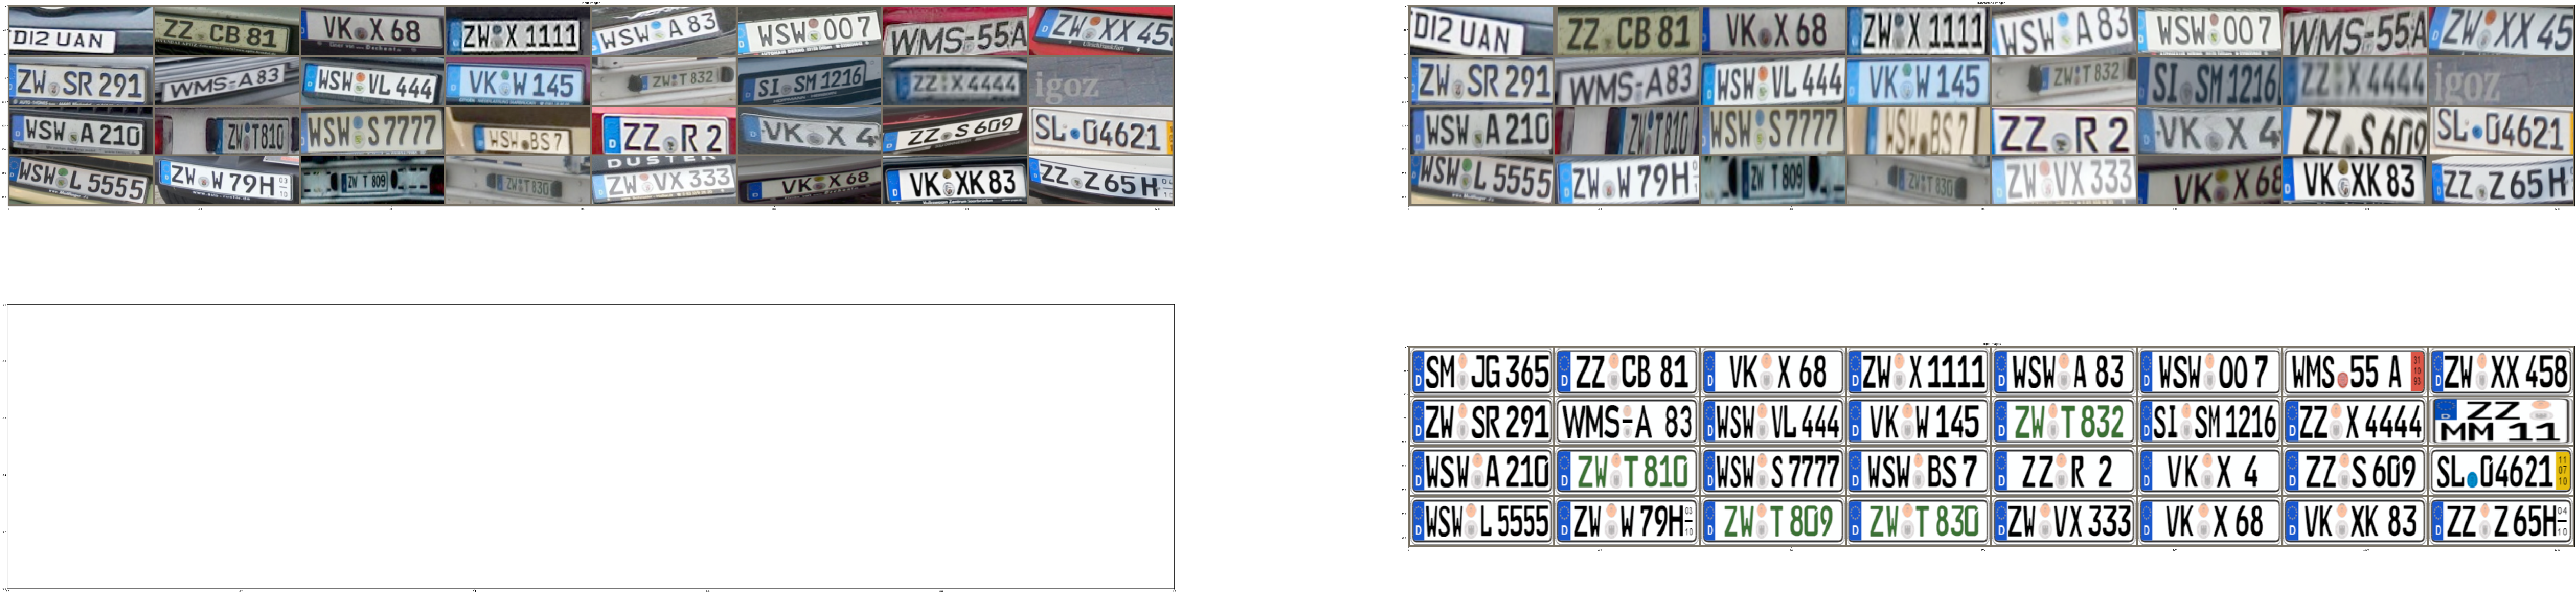

Train Epoch: 6 	Loss: 4.176188
Train Epoch: 7 	Loss: 4.215771
Train Epoch: 8 	Loss: 4.655699
Train Epoch: 9 	Loss: 4.292284
Train Epoch: 10 	Loss: 4.379122


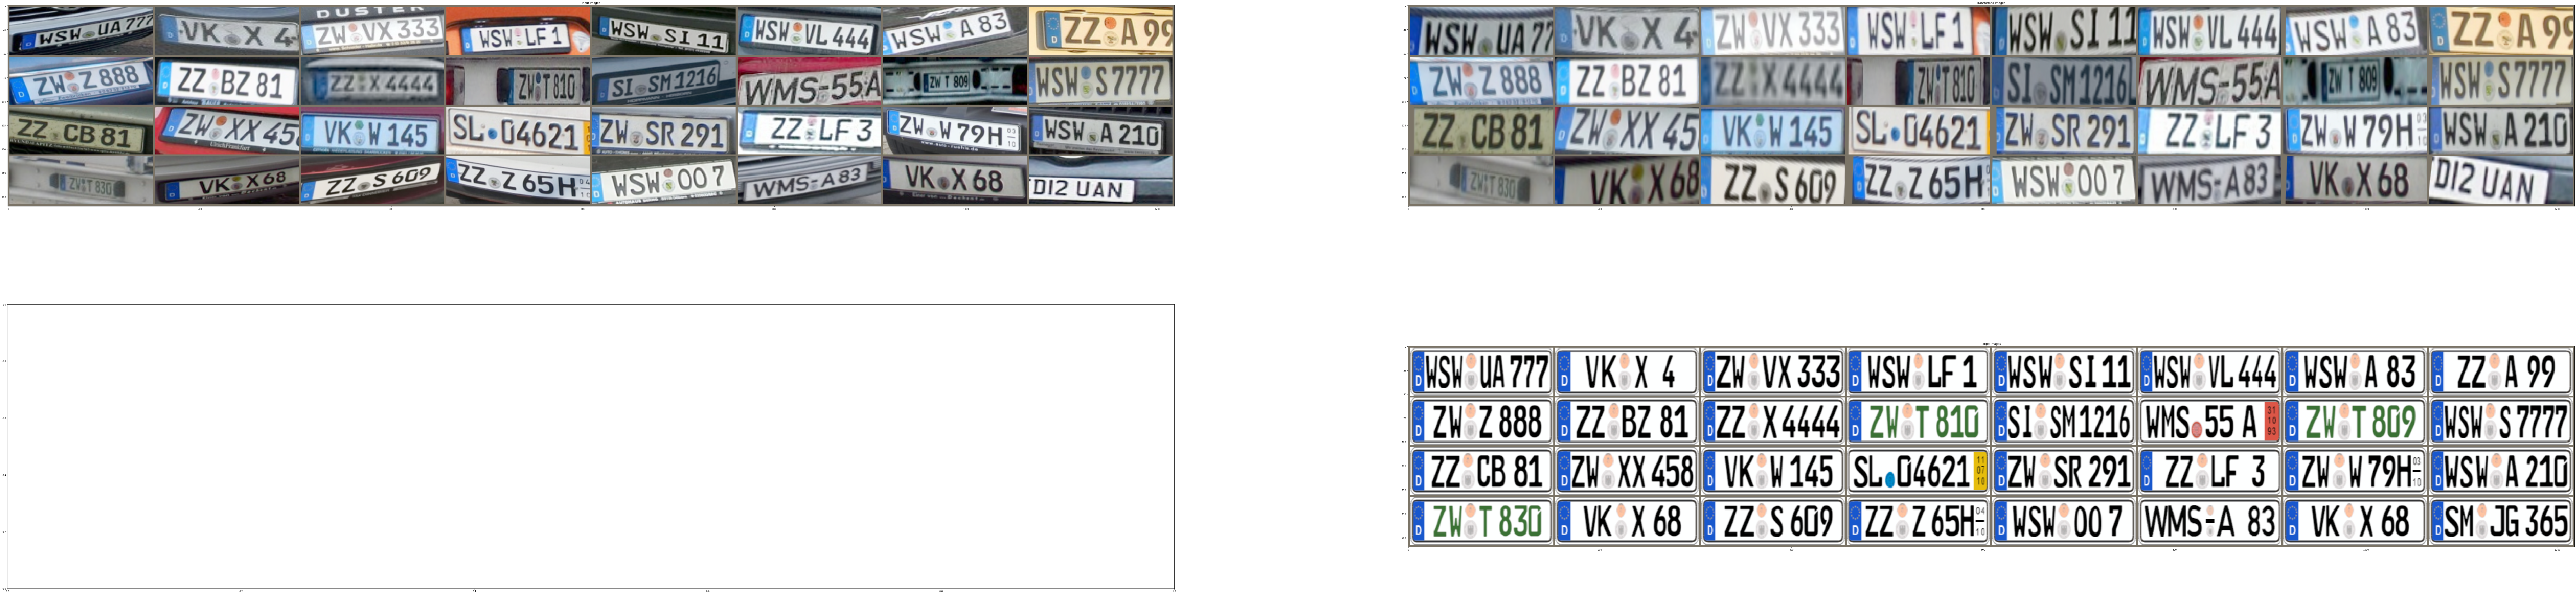

Train Epoch: 11 	Loss: 4.138077
Train Epoch: 12 	Loss: 4.312426
Train Epoch: 13 	Loss: 4.304937
Train Epoch: 14 	Loss: 4.420359
Train Epoch: 15 	Loss: 3.895346


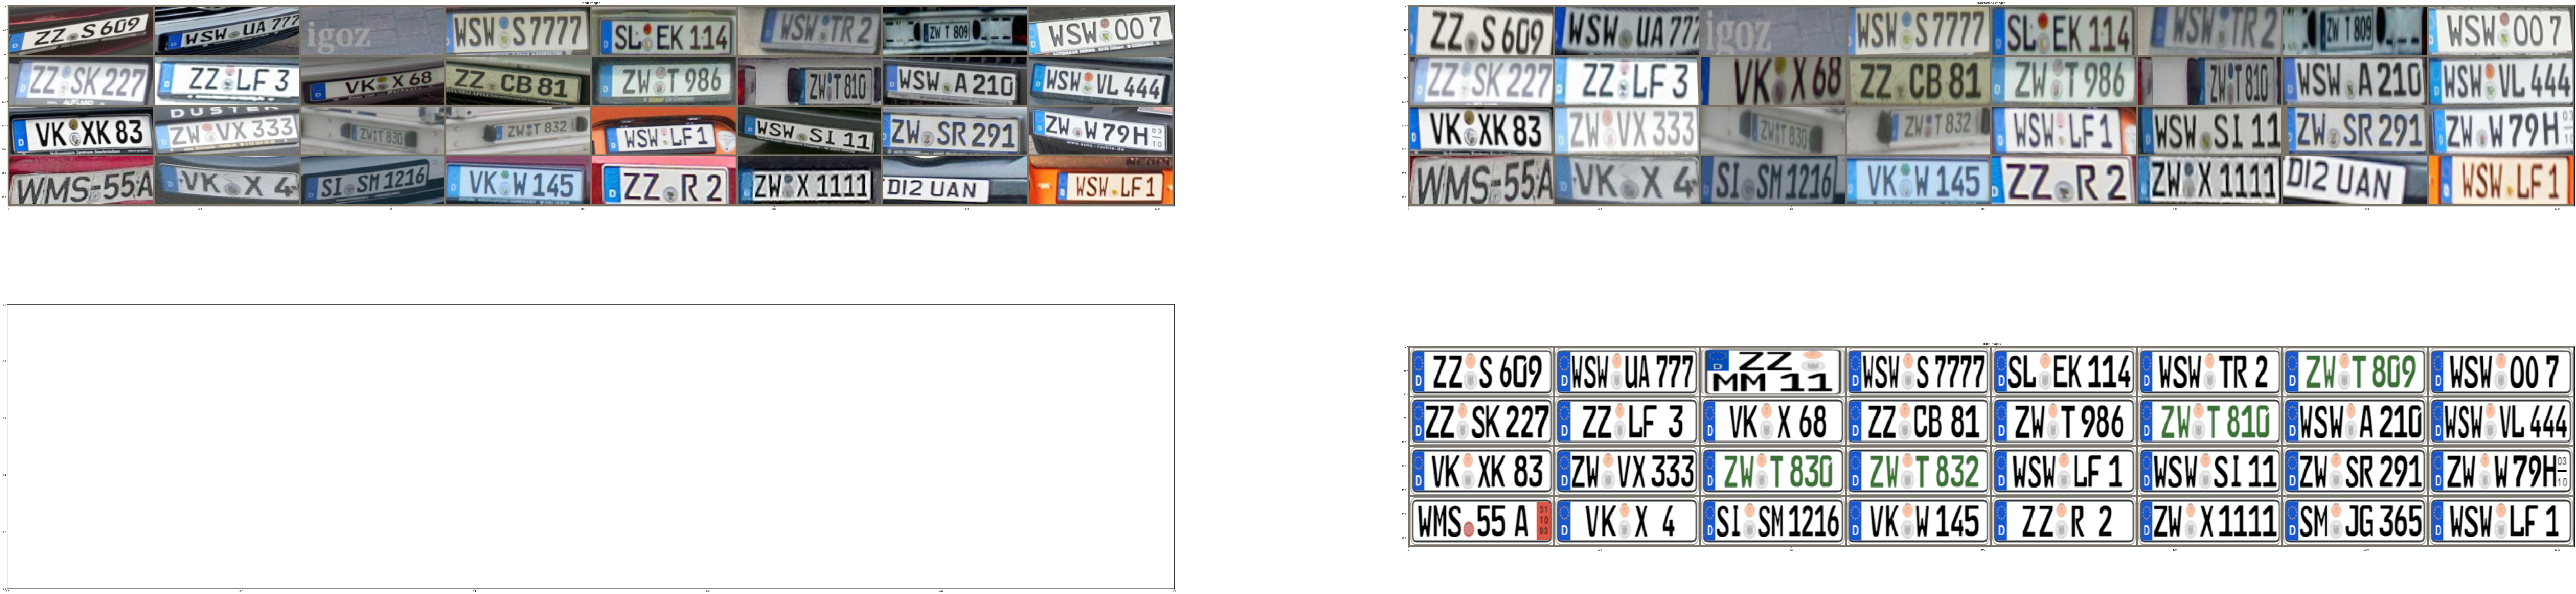

Train Epoch: 16 	Loss: 3.829491
Train Epoch: 17 	Loss: 3.802201
Train Epoch: 18 	Loss: 4.530406
Train Epoch: 19 	Loss: 3.790347
Train Epoch: 20 	Loss: 4.047090


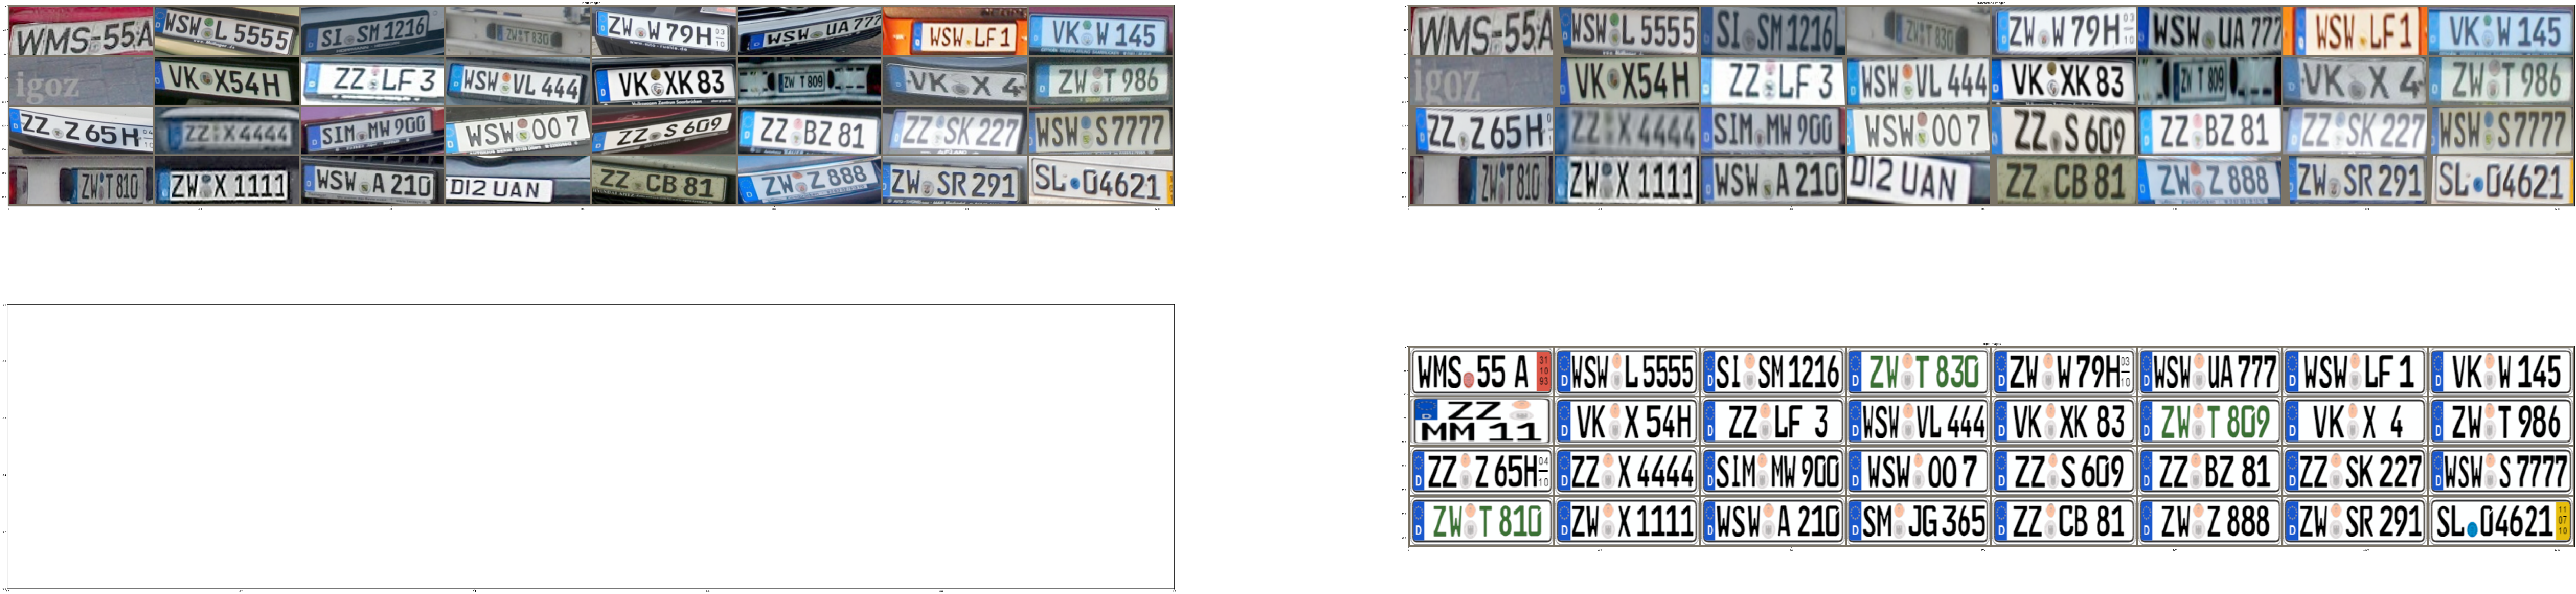

In [10]:
for epoch in range(0, 20):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.l1_loss(output, target) + F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch+1, loss.item()))
    if (epoch+1) % 5 == 0:
        visualize_stn()
        plt.show()

In [0]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }, '/content/data/STN_bigdataset_200.pth')